In [1]:
import bayes3d as b
import jax.numpy as jnp
import jax
import os
import matplotlib.pyplot as plt
import jax.tree_util as jtu
from tqdm import tqdm

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [36]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7009/static/


In [4]:
b.RENDERER = None
intrinsics = b.Intrinsics(
    height=100,
    width=100,
    fx=100.0, fy=100.0,
    cx=50.0, cy=50.0,
    near=0.01, far=50.0
)

b.setup_renderer(intrinsics)

b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(),"sample_objs/table.obj"))
b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(),"sample_objs/box_large.obj"))
b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(),"sample_objs/orange.obj"))

Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


In [7]:
table_pose = b.t3d.inverse_pose(
    b.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 2.6, 2.3]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 1.0, 0.0]),
    )
)
all_box_dims = b.RENDERER.model_box_dims
key = jax.random.PRNGKey(13)
OUTLIER_VOLUME = 1000.0

In [8]:
jnp.zeros((1,3))

Array([[0., 0., 0.]], dtype=float32)

In [68]:
def get_poses(contact_params, ids):
    full_ids = jnp.concatenate([jnp.array([0]), ids])
    root_poses = jnp.tile(table_pose[None,...], (ids.shape[0] + 1, 1,1))
    return full_ids, b.scene_graph.poses_from_scene_graph(
        root_poses,
        b.RENDERER.model_box_dims[full_ids],
        jnp.concatenate([jnp.array([-1]), jnp.full(ids.shape, 0)]),
        jnp.concatenate([jnp.zeros((1,3)), contact_params]),
        jnp.full(full_ids.shape, 0),
        jnp.full(full_ids.shape, 1),
    )

def render_depth(contact_params, ids):
    full_ids, poses = get_poses(contact_params, ids)
    return b.RENDERER.render(poses, full_ids)[:,:,:3]
render_depth_jit = jax.jit(render_depth)

def score(observed_image, contact_params, ids, variance, outlier_prob):
    rendered = render_depth(contact_params, ids)
    b.threedp3_likelihood(observed_image, rendered, variance, outlier_prob, OUTLIER_VOLUME, 1)

def viz_trace(contact_params, ids):
    all_ids, poses = get_poses(contact_params, ids)
    colors = b.viz.distinct_colors(max(10, len(all_ids)))
    b.clear()
    for (i,(id,p)) in enumerate(zip(all_ids, poses)):
        b.show_trimesh(f"obj_{i}", b.RENDERER.meshes[id],color=colors[i])
        b.set_pose(f"obj_{i}", p)

    depth = render_depth_jit(contact_params, ids)
    b.show_cloud("depth", depth[:,:,:3].reshape(-1,3))

contact_bounds = jnp.array([jnp.array([-2.5, -2.5, -2*jnp.pi]), jnp.array([2.5, 2.5, 2*jnp.pi])]),

In [69]:
observed_depth[...,2]

Array([[50.       , 50.       , 50.       , ..., 50.       , 50.       ,
        50.       ],
       [50.       , 50.       , 50.       , ..., 50.       , 50.       ,
        50.       ],
       [50.       , 50.       , 50.       , ..., 50.       , 50.       ,
        50.       ],
       ...,
       [ 1.9686148,  1.9686148,  1.9686148, ...,  1.9686148,  1.9686148,
         1.9686148],
       [ 1.9563906,  1.9563906,  1.9563906, ...,  1.9563906,  1.9563906,
         1.9563906],
       [ 1.9443177,  1.9443177,  1.9443177, ...,  1.9443177,  1.9443177,
         1.9443177]], dtype=float32)

In [70]:
N = 2
ids = jnp.array([1, 1])
key = jax.random.PRNGKey(10)
contact_params = jnp.array([
    [0.0, 0.0, jnp.pi/2],
    [1.0, 0.0, jnp.pi/3],
])

observed_depth = render_depth_jit(contact_params, ids)
viz_trace(contact_params, ids)

In [10]:
enum, enum_score, enum_parallel, enum_score_parallel  = b.genjax.make_enumerator([f"contact_params_3"])

In [53]:
bounds = 1.5
grid = b.make_translation_grid_enumeration_3d(
    -bounds, -bounds, -0.0,
    bounds, bounds, 0.0,
    50,50,1
)

In [54]:
scores = enum_score_parallel(trace, key, grid)

In [58]:
valid_indices = jnp.where(jnp.abs(scores - scores.max()) < 0.001)

In [59]:
traces = enum_parallel(trace, key, grid[valid_indices])

In [60]:
poses = b.genjax.get_poses(traces)[:,3,:,:][:,None,...]

In [61]:
poses.shape

(208, 1, 4, 4)

In [62]:
img = b.RENDERER.render_many(poses, jnp.array([2 for _ in range(len(valid_indices))]))

In [63]:
jnp.any(img[:,:,:,2] < 50.0)

Array(True, dtype=bool)

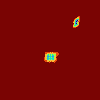

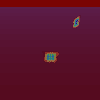

In [66]:
posterior_viz = b.get_depth_image(img.mean(0)[:,:,2])
b.overlay_image(b.get_depth_image(trace["image"][:,:,2]), posterior_viz)